## Web scraping in Python

Web scraping is the process of collecting information from the web and putting it in a format that is convenient for data analysis.

In this practical exercise, we will gather rosters for every men's varsity team at Stanford from the website www.gostanford.com. Websites are simply text documents written in the markup language HTML. We will use the libraries `requests` and `BeautifulSoup` to load a website into Python and to navigate its markup content. 

As a first step, we import the above libraries, as well as `pandas` (R style data frames in Python) and `numpy` (Python's main numerical analysis library).

In [19]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import time

We will read in the main website, using the function `requests.get()`, and then load its text into a `BeautifulSoup` object, which makes it easy to extract information from a markup document. 

The main website has several elements with class `dropdownFooter`, which contain lists of links to each sport. Below is a screenshot of these elements.

In [20]:
mainSite = requests.get('http://www.gostanford.com')
soup = BeautifulSoup(mainSite.text.encode('ISO-8859-1'))

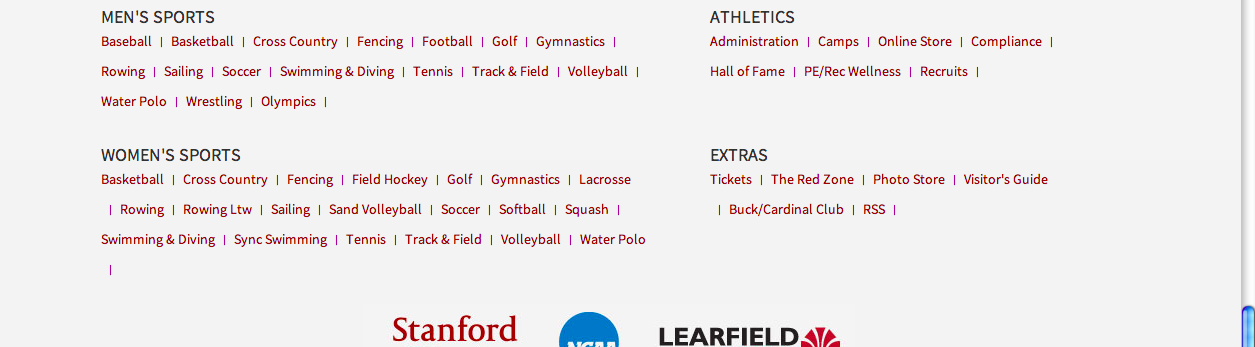

In [21]:
from IPython.core.display import Image 
Image(filename='sportlinks.png') 

To find these elements in `soup`, we use the function `findAll`. The first element found is the list of men's teams, and the second, the list of women's teams. For each one, we can retrieve a list of links (HTML `a` elements) using `findAll('a')`.

In [22]:
dropdownFooters = soup.findAll(attrs={'class':'dropdownFooter'})

menSports = dropdownFooters[0].findAll('a')
womenSports = dropdownFooters[1].findAll('a')

To visualize the list of links, we can simply call the name of `menSports`, which is itself a `BeautifulSoup` object:

In [23]:
menSports

[<a href="/SportSelect.dbml?DB_LANG=C&amp;DB_OEM_ID=30600&amp;SPID=127025&amp;SPSID=749985">Baseball</a>,
 <a href="/SportSelect.dbml?DB_LANG=C&amp;DB_OEM_ID=30600&amp;SPID=127028&amp;SPSID=749997">Basketball </a>,
 <a href="/SportSelect.dbml?DB_LANG=C&amp;DB_OEM_ID=30600&amp;SPID=130812&amp;SPSID=770311">Cross Country</a>,
 <a href="/SportSelect.dbml?DB_LANG=C&amp;DB_OEM_ID=30600&amp;SPID=130509&amp;SPSID=770312">Fencing</a>,
 <a href="/SportSelect.dbml?DB_LANG=C&amp;DB_OEM_ID=30600&amp;SPID=127013&amp;SPSID=749925">Football</a>,
 <a href="/SportSelect.dbml?DB_LANG=C&amp;DB_OEM_ID=30600&amp;SPID=127020&amp;SPSID=749958">Golf</a>,
 <a href="/SportSelect.dbml?DB_LANG=C&amp;DB_OEM_ID=30600&amp;SPID=127016&amp;SPSID=749943">Gymnastics</a>,
 <a href="/SportSelect.dbml?DB_LANG=C&amp;DB_OEM_ID=30600&amp;SPID=130810&amp;SPSID=770514">Rowing</a>,
 <a href="/SportSelect.dbml?DB_LANG=C&amp;DB_OEM_ID=30600&amp;SPID=130410&amp;SPSID=770911">Sailing</a>,
 <a href="/SportSelect.dbml?DB_LANG=C&amp;DB

Now, we will create a dictionary `menSportsWebsites` mapping the name of each sport to the URL for the sport.

In [24]:
menSportsWebsites = {}
for a in menSports:
    menSportsWebsites[a.contents[0]] =  'http://www.gostanford.com'+a.attrs['href']
    
menSportsWebsites.pop('Olympics');    # We eliminate Olympics, as this sport has no roster on the site. 

menSportsWebsites   # Print the dictionary

{u'Baseball': 'http://www.gostanford.com/SportSelect.dbml?DB_LANG=C&DB_OEM_ID=30600&SPID=127025&SPSID=749985',
 u'Basketball ': 'http://www.gostanford.com/SportSelect.dbml?DB_LANG=C&DB_OEM_ID=30600&SPID=127028&SPSID=749997',
 u'Cross Country': 'http://www.gostanford.com/SportSelect.dbml?DB_LANG=C&DB_OEM_ID=30600&SPID=130812&SPSID=770311',
 u'Fencing': 'http://www.gostanford.com/SportSelect.dbml?DB_LANG=C&DB_OEM_ID=30600&SPID=130509&SPSID=770312',
 u'Football': 'http://www.gostanford.com/SportSelect.dbml?DB_LANG=C&DB_OEM_ID=30600&SPID=127013&SPSID=749925',
 u'Golf': 'http://www.gostanford.com/SportSelect.dbml?DB_LANG=C&DB_OEM_ID=30600&SPID=127020&SPSID=749958',
 u'Gymnastics': 'http://www.gostanford.com/SportSelect.dbml?DB_LANG=C&DB_OEM_ID=30600&SPID=127016&SPSID=749943',
 u'Rowing': 'http://www.gostanford.com/SportSelect.dbml?DB_LANG=C&DB_OEM_ID=30600&SPID=130810&SPSID=770514',
 u'Sailing': 'http://www.gostanford.com/SportSelect.dbml?DB_LANG=C&DB_OEM_ID=30600&SPID=130410&SPSID=770911',

The website for each sport has a link to the roster. You can verify this by going to any of the links above. The following function reads the website for a given team, identifies the link to the roster which contains the text **Roster**, and then loads the roster website into a `BeautifulSoup` object.

In [25]:
def GetRoster(url):
    """Outputs a BeautifulSoup object containing the roster for this sport.
    
    Inputs:
    url: Address for a specific sport
    
    """
    sportSite = requests.get(url)
    soup = BeautifulSoup(sportSite.text.encode('ISO-8859-1'))
    a = soup.findAll('a',text='Roster')[0]
    rosterSite = requests.get('http://www.gostanford.com'+a.attrs['href'])
    return BeautifulSoup(rosterSite.text.encode('ISO-8859-1'))

Now, we have a way to create, for each sport, a `BeautifulSoup` with roster information. The roster websites look like this:

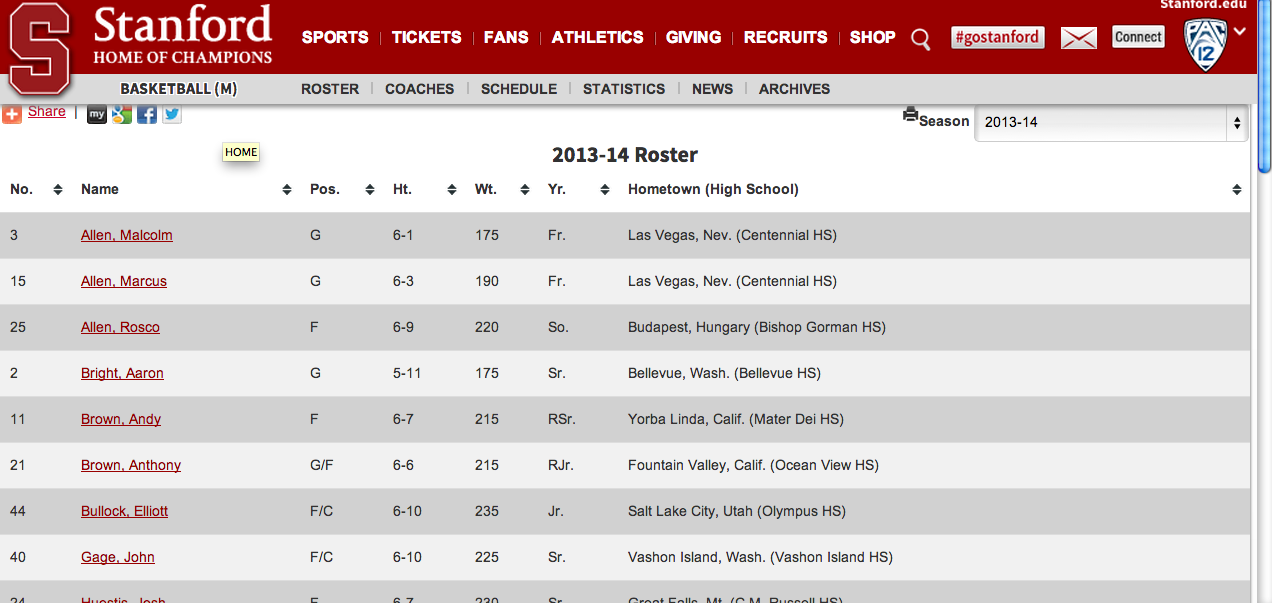

In [26]:
from IPython.core.display import Image 
Image(filename='rostersite.png')

Finally, we create a function which reads the information for each player in this table. In particular, the function extracts, when available: 

- The athlete's home state.
- His height.
- The sport.
- The gender (always male).

Note, that the States listed on the site follow different conventions: two letter postal codes, as well as AP-stype abbreviations. Before we define the function, we create a dictionary of abbreviations which will be useful to have a consistent coding of home states.

In [27]:
stateDict = {'Ore.': 'OR', 'District of Columbia': 'DC', 'Minn.': 'MN', 'Wis.': 'WI', 'S.D.': 'SD', 'Ariz.': 'AZ', 'Ind.': 'IN', 'Idaho': 'ID', 'Kan.': 'KS', 'Calif.': 'CA', 'Md.': 'MD', 'Ky.': 'KY', 'N.H.': 'NH', 'Mont.': 'MT', 'Hawaii': 'HI', 'N.C.': 'NC', 'Ill.': 'IL', 'N.D.': 'ND', 'Colo.': 'CO', 'N.J.': 'NJ', 'Wash.': 'WA', 'Nev.': 'NV', 'Ark.': 'AR', 'Va.': 'VA', 'Conn.': 'CT', 'Neb.': 'NE', 'Alaska': 'AK', 'Vt.': 'VT', 'Ohio': 'OH', 'N.Y.': 'NY', 'Iowa': 'IA', 'Mass.': 'MA', 'Pa.': 'PA', 'La.': 'LA', 'Wyo.': 'WY', 'Tenn.': 'TN', 'N.M.': 'NM', 'Ala.': 'AL', 'Del.': 'DE', 'Ga.': 'GA', 'Mich.': 'MI', 'Mo.': 'MO', 'R.I.': 'RI', 'S.C.': 'SC', 'Okla.': 'OK', 'Fla.': 'FL', 'Miss': 'MS', 'Maine': 'ME', 'W.Va.': 'WV', 'Texas': 'TX', 'Tex.': 'TX', 'Utah': 'UT', 'Aala.': 'AL'}

In [28]:
def ScrapeRoster(sport, soup,stateDict):
    """Scrapes a website with a roster for the following entries: name, home state, and height.
    
    Input:
    sport: The sport (string).
    soup: A BeautifulSoup object containing the website.
    stateDict: Dictionary mapping AP style state names to 2-letter abbreviations.
    
    Output:
    entries: A list of dictionaries, each of which has information on a single player.
    
    """
    table = soup.find(attrs={'id':'roster-table'})    # Find the roster table element
    tbody = table.find('tbody')                       # Find the body of the table
    rows = tbody.findAll('tr')                        # Define a list of all the rows
    entries = []
    
    for row in rows:
        entry = {'gender':'male', 'sport': sport}                    # Initialize the record for this player
        
        genderCol = row.find('td',attrs={'class':'gender'})          # Some sites list men and women on the roster
        if genderCol and genderCol.contents[0].strip()=='Women':     # table. This if statement skips the women.
            break
            
        # Find a column with the name, and read the name from it.
        # The name can be by itself, or inside a link element.
        nameCol = row.find('td',attrs={'class':'name'})            
        if nameCol == None:
            continue
        try:                                                         
            entry['name'] = nameCol.find('a').contents[0].strip()
        except AttributeError:
            entry['name'] = nameCol.contents[0].strip()
        
        # Find a column with the height
        heightCol = row.find('td',attrs={'class':'height'}) 
        # If there is no such column, let height be nan.        
        if heightCol==None:
            entry['height'] = np.nan
        # Transform the height from a 'feet-inches' format to
        # the number of inches as an integer.
        else:
            heightRaw = heightCol.contents[0].strip()
            if heightRaw =='-':
                entry['height'] = np.nan 
            else:
                entry['height'] = int(heightRaw.split('-')[0])*12 + int(heightRaw.split('-')[1])
        
        # Find a column with the weight
        weightCol = row.find('td',attrs={'class':'weight'}) 
        # If there is no such column, let weight be nan.        
        if weightCol==None:
            entry['weight'] = np.nan
        # Transform the height from a 'feet-inches' format to
        # the number of inches as an integer.
        else:
            entry['weight'] = weightCol.contents[0].strip()
            
        
        
        # Read in the hometown, if available
        hometown = row.find('td',attrs={'class':'hometown'}).contents[0].strip()
        try:
            homestate = hometown.split(',')[1].split('(')[0].strip() 
        except IndexError:
            homestate = "NA"
        if homestate in stateDict:
            homestate = stateDict[homestate]
        if not homestate in stateDict.values():
            homestate = "Other"
        entry['homestate'] = homestate
        
        entries.append(entry)
        
    return entries

Finally, we will loop through every sport, and gather records for every player into a list `entries`. Finally, from the list of entries, we create a `pandas` data frame.

In [29]:
entries = []

for sport in menSportsWebsites:
    url = menSportsWebsites[sport]
    soup = GetRoster(url)
    print("\n Scraping: "+sport+" ...\n")
    time.sleep(1)  # This takes a break of 1 second between requests.
    entries.extend(ScrapeRoster(sport,soup,stateDict))

data = pd.DataFrame(entries)


 Scraping: Football ...


 Scraping: Golf ...


 Scraping: Swimming & Diving ...


 Scraping: Sailing ...


 Scraping: Fencing ...


 Scraping: Rowing ...


 Scraping: Cross Country ...


 Scraping: Wrestling ...


 Scraping: Volleyball ...


 Scraping: Basketball  ...


 Scraping: Baseball ...


 Scraping: Water Polo ...


 Scraping: Gymnastics ...


 Scraping: Soccer ...


 Scraping: Tennis ...


 Scraping: Track & Field ...



Let's see what is inside our data frame:

In [30]:
print(data.to_string())

    gender  height homestate                       name              sport weight
0     male      70        LA        Alexander, Terrence           Football    182
1     male      75        OR              Alfieri, Joey           Football    240
2     male      76        CA            Anderson, Kevin           Football    244
3     male      76     Other              Annan, Wesley           Football    285
4     male      75        SC       Arcega-Whiteside, JJ           Football    207
5     male      78        CO            Austin, Brendon           Football    300
6     male      74        CA               Bailey, Jake           Football    186
7     male      75        UT               Barton, Sean           Football    212
8     male      74        CA             Beall, Charlie           Football    215
9     male      73        CA              Beecher, Ryan           Football    230
10    male      71        WA            Branch, Mustafa           Football    218
11    male      

Suppose, we are only interested in players for whom we have every variable. Then, we can drop any rows containing a `nan`:

In [31]:
dataFull = data.dropna(axis=0)
print(dataFull.to_string())

    gender  height homestate                    name        sport weight
0     male      70        LA     Alexander, Terrence     Football    182
1     male      75        OR           Alfieri, Joey     Football    240
2     male      76        CA         Anderson, Kevin     Football    244
3     male      76     Other           Annan, Wesley     Football    285
4     male      75        SC    Arcega-Whiteside, JJ     Football    207
5     male      78        CO         Austin, Brendon     Football    300
6     male      74        CA            Bailey, Jake     Football    186
7     male      75        UT            Barton, Sean     Football    212
8     male      74        CA          Beall, Charlie     Football    215
9     male      73        CA           Beecher, Ryan     Football    230
10    male      71        WA         Branch, Mustafa     Football    218
11    male      71        WA     Brandt-Sims, Isaiah     Football    177
12    male      77        CA           Bright, Davi

To save the data frame, we use the function `to_csv()`.

In [32]:
dataFull.to_csv('rosters3.csv')